In [69]:
!pip install torch torchvision
!pip install tenseal

import tenseal as ts
import gzip
import os
from urllib.request import urlretrieve
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from time import time
from matplotlib import pyplot as plt

# random.seed(8560)
# np.random.seed(8560)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
'''
DATA FETCHING AND PROCESSING ROUTINES
'''

def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    train_images, train_labels = shuffle(train_images, train_labels)
    test_images, test_labels = shuffle(test_images, test_labels)

    return train_images, train_labels, test_images, test_labels


def iris(path=None):
    url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
    # iris_dataset = pd.read_csv(url,index_col=0)
    iris_dataset = pd.read_csv(url)

    dummies = pd.get_dummies(iris_dataset.variety)
    iris_dataset.drop(columns=['variety'], inplace=True)
    iris = pd.concat([iris_dataset, dummies], axis = 1)
    x = iris.drop(columns = ['Setosa', 'Versicolor', 'Virginica'], axis=1).values
    y = iris[['Setosa', 'Versicolor', 'Virginica']].values

    x = x / x.max(axis=0)
    y = y / y.max(axis=0)

    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)

    test_ratio = 0.2
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    x_train = x[train_idxs]
    y_train = y[train_idxs].reshape(len(x[train_idxs]), -1)
    x_test = x[test_idxs]
    y_test = y[test_idxs].reshape(len(x_test), -1)

    return x_train, y_train, x_test, y_test

In [71]:
'''
ACCURACY CALCULATING FUNCTION
'''
def accuracy(features, labels, w1, b1, w2, b2):
    y_hat = []
    correct = 0
    for i in range(len(features)):
        z1 = features[i].dot(w1) + b1
        a1 = 1 / (1 + np.exp(np.negative(z1)))
        z2 = a1.dot(w2) + b2
        a2 = np.exp(z2)/sum(np.exp(z2))
        y_hat.append(a2)
    y_hat = np.array(y_hat)
    # print(y_hat.argmax(axis = 1))
    # print(labels.argmax(axis = 1))
    accuracy = (y_hat.argmax(axis = 1) == labels.argmax(axis = 1)).sum() / len(labels) * 100
    return accuracy

In [72]:
'''
APPROXIMATE TRAINING FUNCTION
'''
# random.seed(8560)
# np.random.seed(8560)

# # # This code snippet train an NN model using following approximation:
# # # Approximate softmax activation function = sigmoid activation function
# # # This article helps me to understand the training algorithm with categorical loss function for multi-class clasification
# # # https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1

# This model is for MNIST dataset
input_neuron = 784
hidden_neuron = [64]
output_neuron = 10
train_images, train_labels, test_images, test_labels = mnist(path=None)

# # This model is for iris dataset
# input_neuron = 4
# hidden_neuron = [5]
# output_neuron = 3
# train_images, train_labels, test_images, test_labels = iris(path=None)

training_accuracy_list = []
testing_accuracy_list = []

# # We are using sigmoid function as an approximation to softmax activation
def training(x_train, y_train, x_test, y_test):

    w1 = np.random.randn(input_neuron, hidden_neuron[0])
    b1 = np.random.randn(hidden_neuron[0])
    w2 = np.random.randn(hidden_neuron[0], output_neuron)
    b2 = np.random.randn(output_neuron)

    w1_delta_mini_batch = np.zeros([input_neuron, hidden_neuron[0]])
    b1_delta_mini_batch = np.zeros([hidden_neuron[0]])
    w2_delta_mini_batch = np.zeros([hidden_neuron[0], output_neuron])
    b2_delta_mini_batch = np.zeros([output_neuron])

    mini_batch = 10
    learning_rate = 1
    Epochs = 50
    for epoch in range(Epochs):
        for i in range(len(x_train)):
            x = x_train[i]
            y = y_train[i]

            z1 = x.dot(w1) + b1
            a1 = 1/(1 + np.exp(-z1))
            z2 = a1.dot(w2) + b2
            a2 = 1/(1 + np.exp(-z2))
            
            b2_delta = a2 - y
            w2_delta = (a1.reshape(-1, 1) @ b2_delta.reshape(1, -1))

            l1_error = w2.dot(b2_delta)
            b1_delta = l1_error * a1 * (1 - a1)
            w1_delta = (x.reshape(-1, 1) @ b1_delta.reshape(1, -1))

            w1_delta_mini_batch += w1_delta
            b1_delta_mini_batch += b1_delta
            w2_delta_mini_batch += w2_delta
            b2_delta_mini_batch += b2_delta

            if (i + 1) % mini_batch == 0:
                w1_grad = w1_delta_mini_batch / mini_batch
                b1_grad = b1_delta_mini_batch / mini_batch
                w2_grad = w2_delta_mini_batch / mini_batch
                b2_grad = b2_delta_mini_batch / mini_batch
                
                w1 -= learning_rate * w1_grad
                b1 -= learning_rate * b1_grad
                w2 -= learning_rate * w2_grad
                b2 -= learning_rate * b2_grad
                
                w1_delta_mini_batch = np.zeros([input_neuron, hidden_neuron[0]])
                b1_delta_mini_batch = np.zeros([hidden_neuron[0]])
                w2_delta_mini_batch = np.zeros([hidden_neuron[0], output_neuron])
                b2_delta_mini_batch = np.zeros([output_neuron])

        tn_acc = np.round(accuracy(x_train, y_train, w1, b1, w2, b2), 2)
        training_accuracy_list.append(tn_acc)
        tt_acc = np.round(accuracy(x_test, y_test, w1, b1, w2, b2), 2)
        testing_accuracy_list.append(tt_acc)
        print(f'Epochs: {epoch+1}\tTraining Accuracy: {tn_acc}\tTest Accuracy: {tt_acc}')
    return w1, b1, w2, b2



w1, b1, w2, b2 = training(train_images, train_labels, test_images, test_labels)

Epochs: 1	Training Accuracy: 94.04	Test Accuracy: 93.59
Epochs: 2	Training Accuracy: 95.04	Test Accuracy: 94.36
Epochs: 3	Training Accuracy: 96.05	Test Accuracy: 95.17
Epochs: 4	Training Accuracy: 96.54	Test Accuracy: 95.54
Epochs: 5	Training Accuracy: 96.49	Test Accuracy: 95.46
Epochs: 6	Training Accuracy: 96.66	Test Accuracy: 95.48
Epochs: 7	Training Accuracy: 96.91	Test Accuracy: 95.49
Epochs: 8	Training Accuracy: 97.32	Test Accuracy: 95.8
Epochs: 9	Training Accuracy: 97.32	Test Accuracy: 95.93
Epochs: 10	Training Accuracy: 97.55	Test Accuracy: 96.03
Epochs: 11	Training Accuracy: 97.58	Test Accuracy: 95.98
Epochs: 12	Training Accuracy: 97.36	Test Accuracy: 95.94
Epochs: 13	Training Accuracy: 97.66	Test Accuracy: 95.97
Epochs: 14	Training Accuracy: 97.5	Test Accuracy: 95.72
Epochs: 15	Training Accuracy: 97.72	Test Accuracy: 95.86
Epochs: 16	Training Accuracy: 98.05	Test Accuracy: 96.24
Epochs: 17	Training Accuracy: 98.12	Test Accuracy: 96.2
Epochs: 18	Training Accuracy: 97.93	Test Ac

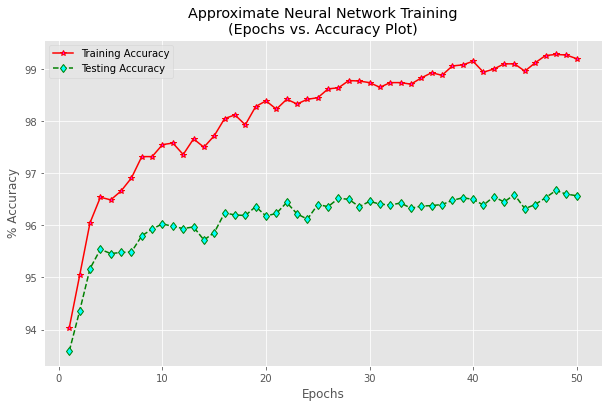

In [73]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 6)

epoch_plot = range(1, len(training_accuracy_list) + 1)
plt.plot(epoch_plot, training_accuracy_list, marker='*', markerfacecolor='magenta', color='red', linestyle='solid', label='Training Accuracy')
plt.plot(epoch_plot, testing_accuracy_list, marker='d', markerfacecolor='cyan', color='green', linestyle='dashed', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.title('Approximate Neural Network Training\n(Epochs vs. Accuracy Plot)')
plt.legend(loc='upper left')
plt.show()